Second goal: Generate a new training set of images of size `target_size` 

In [501]:
import csv 
import pandas as pd 
from PIL import Image, ImageDraw
import itertools
import operator
import random

In [502]:
target_size = [512, 512]

TODO: One problem is that we have to reject any bounding boxes whose size is > target_size

In [503]:
with open('training_data/images/deduped_annotations.csv') as f : 
    ls = list(csv.reader(f))[1:]
    
def to_annotation(l) : 
    # Note swap of 1st and 2nd Y
    return ("training_data/images/" + l[0][11:],int(l[1]),int(l[4]),int(l[3]),int(l[2]),1)

annotations = [to_annotation(l) for l in ls]

In [504]:
ls[0:3]

[['niihau/jpg/1_1920_04_07.jpg', '474', '667', '524', '617', 'P'],
 ['niihau/jpg/1_1920_06_12.jpg', '940', '393', '990', '343', 'B'],
 ['niihau/jpg/1_1920_07_13.jpg', '242', '529', '292', '479', 'P']]

In [505]:
annotations[0:3]

[('training_data/images/1_1920_04_07.jpg', 474, 617, 524, 667, 1),
 ('training_data/images/1_1920_06_12.jpg', 940, 343, 990, 393, 1),
 ('training_data/images/1_1920_07_13.jpg', 242, 479, 292, 529, 1)]

In [506]:
grouped = {}
uniquekeys = []
for k, g in itertools.groupby(sorted(annotations), operator.itemgetter(0)):
    grouped[k]=[item for item in g]
    uniquekeys.append(k)


In [507]:
grouped[uniquekeys[0]]

[('training_data/images/1_1006_30_28.jpg', 888, 657, 938, 707, 1)]

In [508]:
list(filter(lambda k : len(grouped[k]) > 4, uniquekeys))[0]

'training_data/images/1_1171_04_25.jpg'

grouped is now a `dict` from `fname` to `annotations list` where annotation is `x0, y0, x1, y1`

In [509]:
k = 'training_data/images/1_1171_04_25.jpg'
g = grouped[k]
g = [('training_data/images/1_1171_04_25.jpg', 211, 510, 261, 560, 1),
 ('training_data/images/1_1171_04_25.jpg', 253, 462, 303, 512, 1),
 ('training_data/images/1_1171_04_25.jpg', 278, 454, 308, 479, 1),
 ('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1),
 ('training_data/images/1_1171_04_25.jpg', 380, 600, 415, 640, 1)]
grouped[k] = g



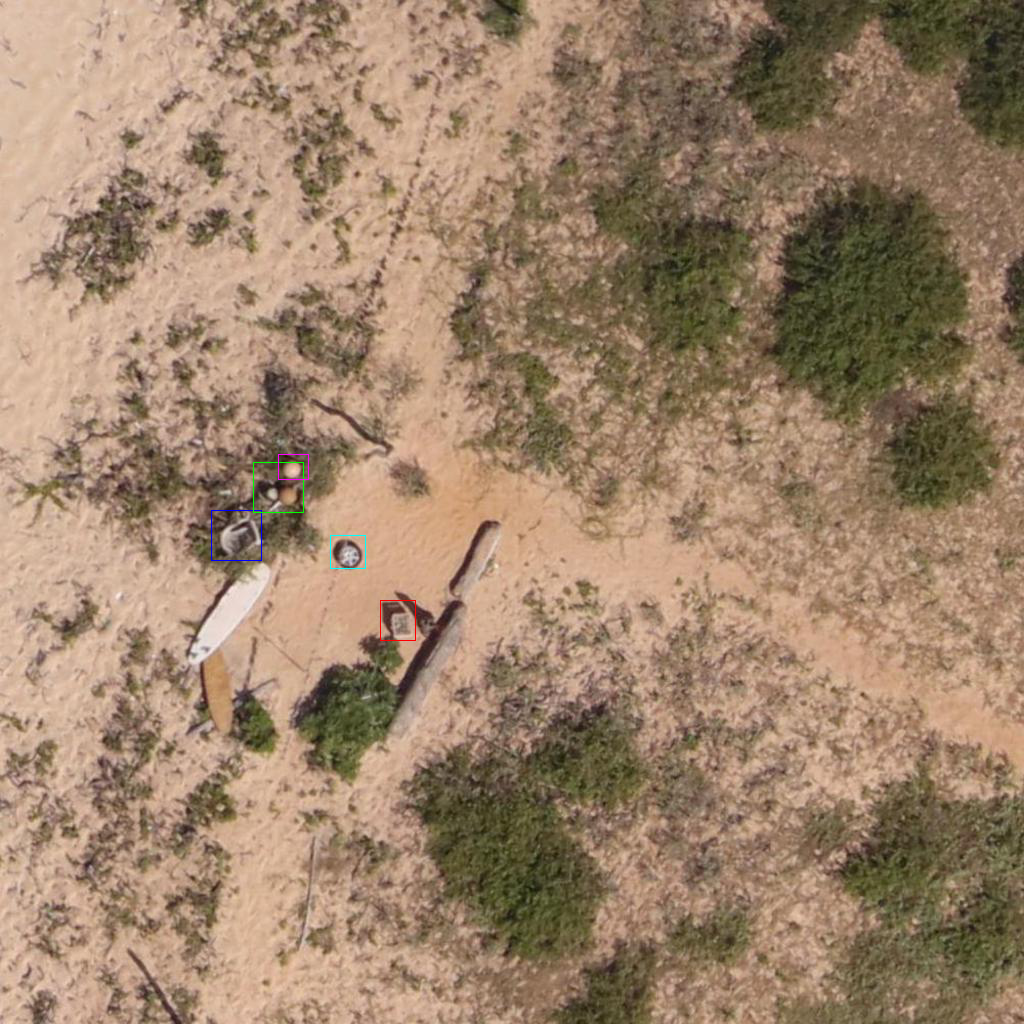

In [510]:
orig = Image.open(g[0][0])
dc = ImageDraw.Draw(orig)
dc.rectangle(g[0][1:5], outline=(0,0,255))
dc.rectangle(g[1][1:5], outline=(0,255,0))
dc.rectangle(g[2][1:5], outline=(255,0,255))
dc.rectangle(g[3][1:5], outline=(0, 255, 255))
dc.rectangle(g[4][1:5], outline=(255, 0, 0))
orig

In [511]:
annotation = g[3]
annotation

('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1)

In [512]:
# Just validates that this target BB can fit within the resized image
# If this is false, reject the BB
def is_valid_span(span_size, span_min, span_max) :
    return span_size > abs(span_max - span_min)

span_min = annotation[1]
span_max = annotation[3]
is_valid_span(256, span_min, span_max)

True

In [513]:
def span_start(span_size, image_max, start) : 
    if start + span_size > image_max : 
        return image_max - span_size
    else : 
        return start

In [514]:
def crop_locFn(target_size, image_size, xStart, yStart) : 
    #print(f"crop_loc({target_size}, {xStart}, {yStart}")
    x = span_start(target_size[0], image_size[0], xStart)
    y = span_start(target_size[1], image_size[1], yStart)
    return (x, y)

crop_locFn((1000,1000), (1024,1024),12,12)

(12, 12)

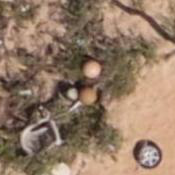

In [515]:
##### Returns cropped image and new bounding box
def cropped_image(srcImg, loc, sz) :
    #print(f"cropped_image(srcImg, {loc}, {sz})")
    return srcImg.crop([loc[0], loc[1], loc[0] + sz[0], loc[1] + sz[1]])
    #newImg = srcImg.copy()
    #dc = ImageDraw.Draw(newImg)
    #dc.rectangle([loc[0], loc[1], loc[0] + sz[0], loc[1] + sz[1]], outline = (255,0,0))
    #return newImg

def test(fname) :
    img = Image.open(fname)
    return cropped_image(img, [200,400], [175,175] )

test(annotation[0])

In [516]:
def scaled_bb (original_size, original_bb, crop_x, crop_y, target_size) :
    #print(f"scaled_bb({original_size}, {original_bb}, {crop_x}, {crop_y}, {target_size})")
    normalized_bb = [ original_bb[0] / original_size[0], original_bb[1] / original_size[1], original_bb[2] / original_size[0], original_bb[3] / original_size[1] ]
    normalized_crop = [crop_x / original_size[0], crop_y / original_size[1]]
    #print(f"normalized_bb {normalized_bb}")
    #print(f"normalized_crop {normalized_crop}")
    shifted_bb = [normalized_bb[0] - normalized_crop[0], normalized_bb[1] - normalized_crop[1], normalized_bb[2] - normalized_crop[0], normalized_bb[3] - normalized_crop[1]]
    #print(f"shifted_bb {shifted_bb}")
    scaled_bb = [shifted_bb[0] * original_size[0], shifted_bb[1] * original_size[1], shifted_bb[2] * original_size[0], shifted_bb[3] * original_size[1]]
    #print(f"scaled_bb {scaled_bb}")
    return scaled_bb

def testIdentity(annotation) :
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 0
    crop_y = 0
    target_size = [1024,1024]
    same = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"The should be the same \n{same} = {bb}")

def testScale(annotation) :
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 0
    crop_y = 0
    target_size = [512,512]
    r = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"Should be same, because scale is irrelevant to BB size and crop is at 0,0 \n{bb} -> halfSize {r}")

def testShift(annotation) :
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 100
    crop_y = 50
    target_size = [1024,1024]
    r = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"X should shift 100, Y should shift 50 \n{bb} -> shift {r}")    

def testSAndS() :
    bb = [200, 220, 230, 240]
    original_size = [1000, 1000]
    crop_x = 100
    crop_y = 100
    target_size = [100, 100]
    r = scaled_bb(original_size, bb, crop_x, crop_y, target_size)
    print(f"X & Y should both shift 100, no change in size \n{bb} -> sAnds {r}")
    
def test(annotation) : 
    bb = annotation[1:5]
    original_size = [1024, 1024]
    crop_x = 233
    crop_y = 442
    target_size = [256,256]
    return scaled_bb(original_size, bb, 0, 0, original_size)

testIdentity(annotation)
testScale(annotation)
testShift(annotation)
testSAndS()

The should be the same 
[330.0, 535.0, 365.0, 568.0] = (330, 535, 365, 568)
Should be same, because scale is irrelevant to BB size and crop is at 0,0 
(330, 535, 365, 568) -> halfSize [330.0, 535.0, 365.0, 568.0]
X should shift 100, Y should shift 50 
(330, 535, 365, 568) -> shift [230.0, 485.0, 265.0, 518.0]
X & Y should both shift 100, no change in size 
[200, 220, 230, 240] -> sAnds [100.0, 120.0, 130.0, 139.99999999999997]


In [517]:
def crop(target_size, src_bb, srcImg, xRandFn, yRandFn) :
    xStart = xRandFn(src_bb[0])
    yStart = yRandFn(src_bb[1])
    image_size = srcImg.size
    cropLoc = crop_locFn(target_size, image_size, xStart, yStart)
    cropSz = target_size
    ci = cropped_image(srcImg, cropLoc, cropSz)
    new_bb = scaled_bb(image_size, src_bb, xStart, yStart, target_size)
    return (ci, cropLoc, new_bb)

(ci, cropLoc, new_bb) = crop([1024,1024], annotation[1:5], Image.open(annotation[0]), lambda x : 0, lambda y : 0)
print(f"cropLoc should be [0,0] {cropLoc}")
print(f"new_bb should be same {annotation[1:5]} {new_bb}")

cropLoc should be [0,0] (0, 0)
new_bb should be same (330, 535, 365, 568) [330.0, 535.0, 365.0, 568.0]


cropLoc should be [300,500] (300, 500)
new_bb should be  [30.0, 35.0, 65.0, 68.0]


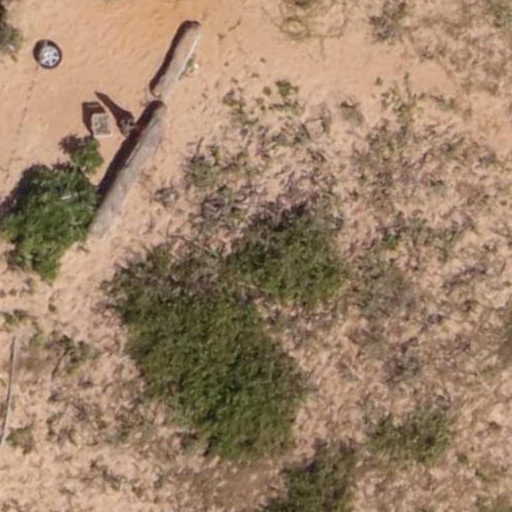

In [518]:
(ci, cropLoc, new_bb) = crop([512,512], [330,535,365,568], Image.open(annotation[0]), lambda x : 300, lambda y : 500)
print(f"cropLoc should be [300,500] {cropLoc}")
print(f"new_bb should be  {new_bb}")

ci

New bounding box is [330.0, 535.0, 365.0, 568.0]


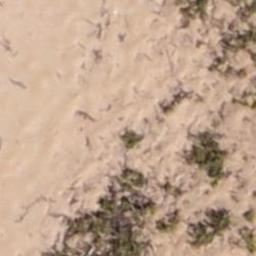

In [519]:
def test(annotation) : 
    srcImg = Image.open(annotation[0])
    target_size = [256,256]
    src_bb = annotation[1:5]
    xRandFn = lambda x : 0
    yRandFn = xRandFn
    return crop(target_size, src_bb, srcImg, xRandFn, yRandFn)

(ci, cropLoc, new_bb) = test(annotation)
print(f"New bounding box is {new_bb}")
ci

annotation -> ('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1)
cropLoc -> (0, 0), bb -> [330.0, 535.0, 365.0, 568.0]


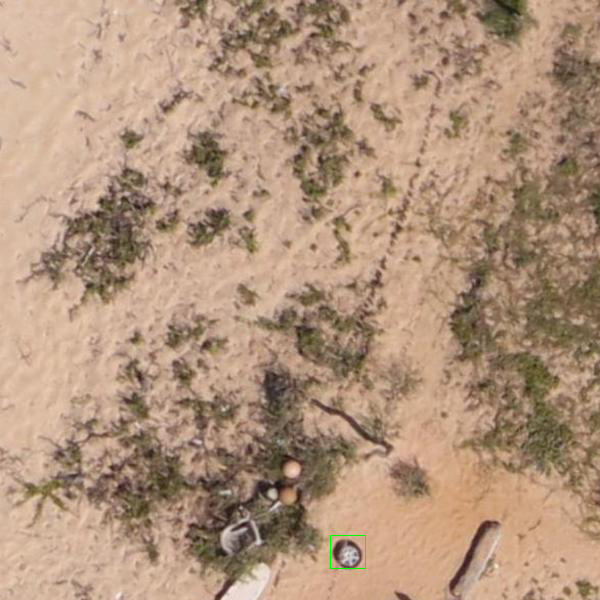

In [520]:
def tryIt (annotation, target_size, fnX, fnY) :
    target_bb = annotation[1:5]
    fname = annotation[0]
    img = Image.open(fname)
    return crop(target_size, target_bb, img, fnX, fnY)

def addBB(imgIn, r) : 
    #print(f"addBB(imgIn, {r})")
    img = imgIn.copy()
    draw = ImageDraw.Draw(img)
    draw.rectangle([r[0], r[1], r[2], r[3]], outline=(0,255,0))
    return img

print(f"annotation -> {annotation}")
(croppedImg, cropLoc, bb) = tryIt(annotation, [600,600], lambda x : 0, lambda y : 0)
print(f"cropLoc -> {cropLoc}, bb -> {bb}")
addBB(croppedImg,bb)

(200, 380)
[130.0, 155.0, 165.0, 188.0]


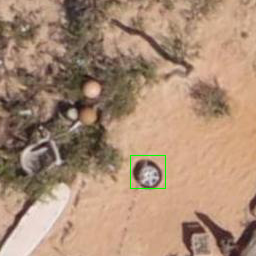

In [521]:
(croppedImg, cropLoc, bb) = tryIt(annotation, [256,256], lambda x : 200, lambda y : 380)
print(cropLoc)
print(bb)
addBB(croppedImg, bb)

NOW! In an example such as the above, I definitely need to add BBs for the _other_ targets in the frame!

In [522]:
anns = grouped[annotation[0]]
anns

[('training_data/images/1_1171_04_25.jpg', 211, 510, 261, 560, 1),
 ('training_data/images/1_1171_04_25.jpg', 253, 462, 303, 512, 1),
 ('training_data/images/1_1171_04_25.jpg', 278, 454, 308, 479, 1),
 ('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1),
 ('training_data/images/1_1171_04_25.jpg', 380, 600, 415, 640, 1)]

In [523]:
annotation

('training_data/images/1_1171_04_25.jpg', 330, 535, 365, 568, 1)

In [524]:
def crop_pt_normalized(crop_loc, orig_img_size) :
    return [crop_loc[0] / orig_img_size[0], crop_loc[1] / orig_img_size[1]]

In [525]:
# Returns a rectangle shifted by `cp`, with values constrained to the range 0,1
def shifted_normalized(a, cp) : 
    a0 = max(0, a[0] - cp[0])
    a1 = max(0, a[1] - cp[1])
    a2 = min(1, a[2] - cp[0])
    a3 = min(1, a[3] - cp[1])
    if a2 < 0 or a3 < 0 or a0 > 1 or a1 > 1:
        return None
    
    return [a0, a1, a2, a3]


In [526]:
# Normalizes a rect
def raw_pct(rect, sz) : 
    return [rect[0] / sz[0], rect[1] / sz[1], rect[2] / sz[0], rect[3] / sz[1]]

raw_pct([256, 256, 768, 768], [1024,1024])

[0.25, 0.25, 0.75, 0.75]

def normalized_bbs(crop_loc, orig_img_size, annotation, grouped) : 
    anns = grouped[annotation[0]].copy()
    #anns.remove(annotation)
    full_scale_bounding_boxes = [a[1:5] for a in anns]
    tupleized = [tuple(a) for a in full_scale_bounding_boxes]
    raw_normalized = [ raw_pct(rect, orig_img_size) for rect in tupleized]
    print(f"The tupleized input annotations are : {tupleized}")
    print(f"Those, normalized to original size are: {raw_normalized}")
    cpn = crop_pt_normalized(crop_loc, orig_img_size)
    print(f"The crop point, normalized is {cpn}")
    a3 = [some for some in [shifted_normalized(a, cpn) for a in raw_normalized] if some]
    print(f"The shifted normalized is {a3}")
    return a3

ann = g[0]
normalized_bbs((100,100), (1024,1024), ann, grouped)

In [527]:
def add_normalized_bb(imgIn, nbb) :
    img = imgIn.copy()
    draw = ImageDraw.Draw(img)
    imgSize = img.size
    x0 = nbb[0] * imgSize[0]
    x1 = nbb[2] * imgSize[0]
    y0 = nbb[1] * imgSize[1]
    y1 = nbb[3] * imgSize[1]
    r = [x0, y0, x1, y1]
    draw.rectangle(r, outline=(0,255,0))
    return img

#Identity test
target_size = [1024,1024]
target_bb = ann[1:5]
fname = ann[0]
img = Image.open(fname)
fn = lambda x : 0
(ci, cropLoc, new_bb) = crop(target_size, target_bb, img, fn, fn)
nbbs = normalized_bbs(cropLoc, img.size, ann, grouped) 
print(f"There are {len(nbbs)} normalized bounding boxes within the image")
for nbb in nbbs : 
    print(nbb)
    ci = add_normalized_bb(ci, nbb)
ci

In [541]:
def nbb_single(bb, crop_loc, target_size) :
    p0 = (bb[0] - crop_loc[0]) / target_size[0] 
    p1 = (bb[1] - crop_loc[1]) / target_size[1]
    p2 = ((bb[0] - crop_loc[0]) + (bb[2] - bb[0])) / target_size[0]
    p3 = ((bb[1] - crop_loc[1]) + (bb[3] - bb[1])) / target_size[1]
    nbb = [max(0,p0), max(0,p1), min(1,p2), min(1,p3)]
    print(f"Converting {bb} to {nbb}")
    return nbb

def normalized_bbs(annotation, grouped, crop_loc, target_size) : 
    anns = grouped[annotation[0]].copy()
    bbs = [a[1:5] for a in anns]
    return [nbb_single(bb, crop_loc, target_size) for bb in bbs]

target_bb -> [330, 535, 365, 568]
Normalized, that's -> 0.322265625, 0.5224609375, 0.3564453125, 0.5546875
Converting [330, 535, 365, 568] to [0.625, 0.390625, 0.76171875, 0.51953125]
Converting (211, 510, 261, 560) to [0.16015625, 0.29296875, 0.35546875, 0.48828125]
Converting (253, 462, 303, 512) to [0.32421875, 0.10546875, 0.51953125, 0.30078125]
Converting (278, 454, 308, 479) to [0.421875, 0.07421875, 0.5390625, 0.171875]
Converting (330, 535, 365, 568) to [0.625, 0.390625, 0.76171875, 0.51953125]
Converting (380, 600, 415, 640) to [0.8203125, 0.64453125, 0.95703125, 0.80078125]


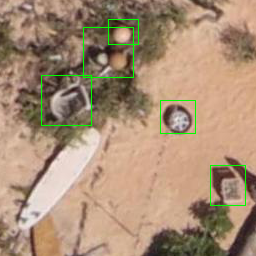

In [542]:
# Crop test
target_size = [256,256]
target_bb = ann[1:5]
target_bb = [330, 535, 365, 568]
print(f"target_bb -> {target_bb}")
print(f"Normalized, that's -> {target_bb[0]/1024}, {target_bb[1]/1024}, {target_bb[2] / 1024}, {target_bb[3]/1024}")
fname = ann[0]
img = Image.open(fname)
fnX = lambda x : 170
fnY = lambda y : 435
(ci, crop_loc, new_bb) = crop(target_size, target_bb, img, fnX, fnY)

#p0 = (target_bb[0] - fnX(0)) / target_size[0] 
#p1 = (target_bb[1] - fnY(0)) / target_size[1]
#p2 = ((target_bb[0] - fnX(0)) + (target_bb[2] - target_bb[0])) / target_size[0]
#p3 = ((target_bb[1] - fnY(0)) + (target_bb[3] - target_bb[1])) / target_size[1]
#nbb = [p0, p1, p2, p3]
nbb = nbb_single(target_bb, crop_loc, target_size)
#print(f"nbb is {nbb}")
#print(f"normalized width is {p2 - p0}")
#print(f"Which is {(p2 - p0) * 512} pixels")

ci = add_normalized_bb(ci, nbb)

nbbs = normalized_bbs(ann, grouped, crop_loc, target_size) 
for nbb in nbbs : 
#   print(f"bb -> {nbb}")
   ci = add_normalized_bb(ci, nbb)
ci

Converting (211, 510, 261, 560) to [0.31640625, 0.208984375, 0.4140625, 0.306640625]
Converting (253, 462, 303, 512) to [0.3984375, 0.115234375, 0.49609375, 0.212890625]
Converting (278, 454, 308, 479) to [0.447265625, 0.099609375, 0.505859375, 0.1484375]
Converting (330, 535, 365, 568) to [0.548828125, 0.2578125, 0.6171875, 0.322265625]
Converting (380, 600, 415, 640) to [0.646484375, 0.384765625, 0.71484375, 0.462890625]


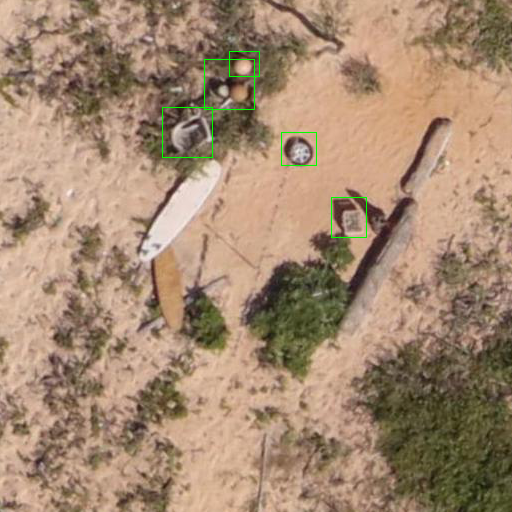

In [543]:
target_size = [512,512]
target_bb = ann[1:5]
fname = ann[0]
img = Image.open(fname)
fnX = lambda x : x - 20
fnY = lambda y : y - 20
(ci, crop_loc, new_bb) = crop(target_size, target_bb, img, fn, fn)
nbbs = normalized_bbs(ann, grouped, crop_loc, target_size) 
for nbb in nbbs : 
    ci = add_normalized_bb(ci, nbb)
ci

Converting (211, 510, 261, 560) to [0.208984375, 0.349609375, 0.306640625, 0.447265625]
Converting (253, 462, 303, 512) to [0.291015625, 0.255859375, 0.388671875, 0.353515625]
Converting (278, 454, 308, 479) to [0.33984375, 0.240234375, 0.3984375, 0.2890625]
Converting (330, 535, 365, 568) to [0.44140625, 0.3984375, 0.509765625, 0.462890625]
Converting (380, 600, 415, 640) to [0.5390625, 0.525390625, 0.607421875, 0.603515625]


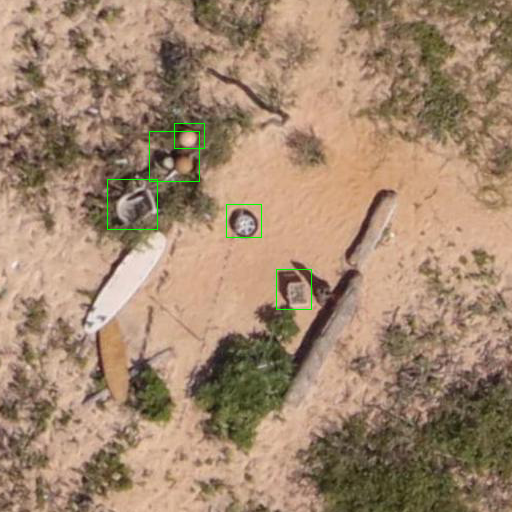

In [552]:
target_size = [512,512]
target_bb = ann[1:5]
fname = ann[0]
img = Image.open(fname)
fnX = lambda x : random.randint(0,x)
fnY = lambda y : random.randint(0,y)
(ci, crop_loc, new_bb) = crop(target_size, target_bb, img, fnX, fnY)
nbbs = normalized_bbs(ann, grouped, crop_loc, target_size) 
for nbb in nbbs : 
    ci = add_normalized_bb(ci, nbb)
ci